# Project 2-  Customer Churn Prediction
## 1. Problem Definition
### We'll predict whether a customer will leave a service based on their usage pattern and demographic

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
from lazypredict.Supervised import LazyClassifier

np.random.seed(42)

#Load the Telco custome chiun dataset (downloading from a common source)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
data = pd.read_csv(url)

# Display basic information about the dataset
print(f"Dataset Shape: {data.shape}")
print(f"First five rows: {data.head()}")
display(data)


Dataset Shape: (7043, 21)
First five rows:    customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No
2  3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3  7795-CFOCW    Male              0  ...          42.30      1840.75     No
4  9237-HQITU  Female              0  ...          70.70       151.65    Yes

[5 rows x 21 columns]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [93]:
data.info()
#missing values
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [94]:
# Check unique values in the target column
print("\nChurn Distribution:")
print(data['Churn'].value_counts())
print(data['Churn'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))



Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     73.46%
Yes    26.54%
Name: proportion, dtype: object


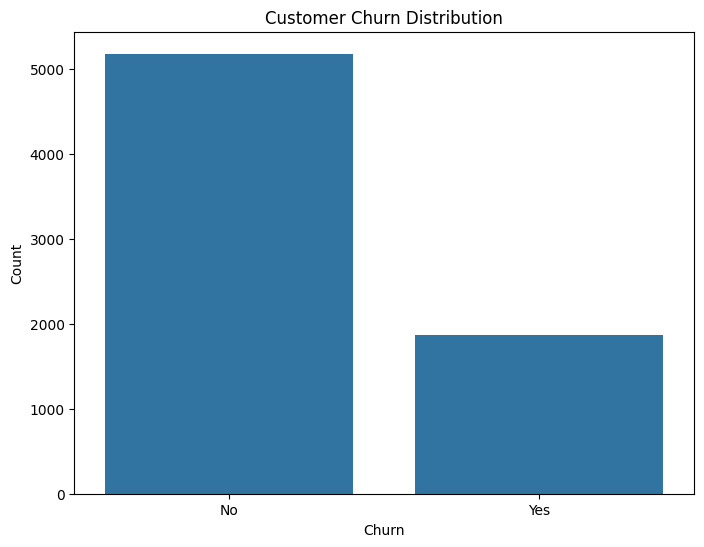

In [95]:
plt.figure(figsize=(8,6))
sns.countplot(x='Churn', data=data)
plt.title('Customer Churn Distribution')
plt.ylabel('Count')
plt.show()

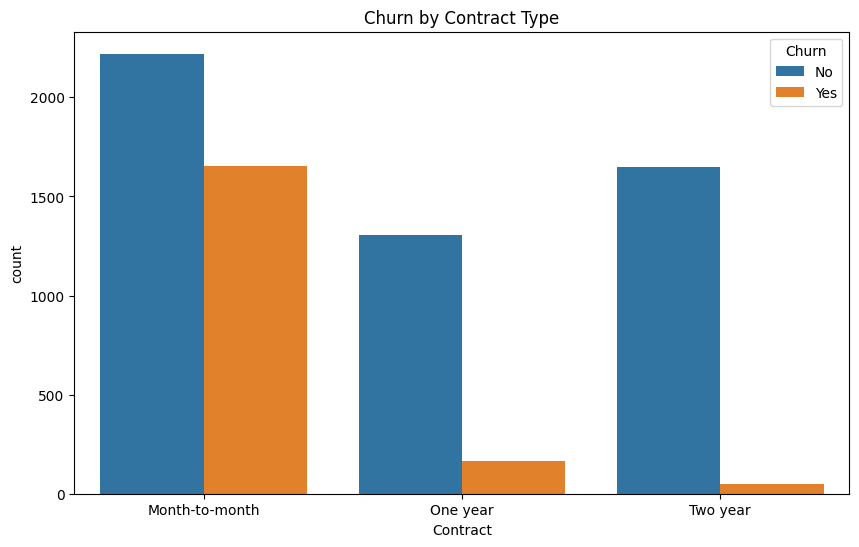

In [96]:
#Examine some key features related to Churn
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService', 
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

plt.figure(figsize=(10,6))
sns.countplot(x='Contract', hue='Churn', data=data)
plt.title('Churn by Contract Type')
plt.show()

In [97]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
#Convert TotalCharges to numeric (it might be loaded as object)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].isna().sum()
#check rows with missing Totalcharges
print("Rows with missing TotalCharges:")
print(data[data['TotalCharges'].isna()])

Rows with missing TotalCharges:
      customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
488   4472-LVYGI  Female              0  ...          52.55          NaN     No
753   3115-CZMZD    Male              0  ...          20.25          NaN     No
936   5709-LVOEQ  Female              0  ...          80.85          NaN     No
1082  4367-NUYAO    Male              0  ...          25.75          NaN     No
1340  1371-DWPAZ  Female              0  ...          56.05          NaN     No
3331  7644-OMVMY    Male              0  ...          19.85          NaN     No
3826  3213-VVOLG    Male              0  ...          25.35          NaN     No
4380  2520-SGTTA  Female              0  ...          20.00          NaN     No
5218  2923-ARZLG    Male              0  ...          19.70          NaN     No
6670  4075-WKNIU  Female              0  ...          73.35          NaN     No
6754  2775-SEFEE    Male              0  ...          61.90          NaN     No

[11 row

In [98]:
#Look at the relationship with Tenure
print("\nTenure for rows with missing TotalCharges:")
print(data[data['TotalCharges'].isna()]['tenure'])
# Because tenure for all the rows are ZERO, it could be because the customers are new
#Set TotalCharges equal to MonthlyCharges for these new customer
data.loc[data['TotalCharges'].isna(), 'TotalCharges'] = data.loc[data['TotalCharges'].isna(), 'MonthlyCharges']

# Confirm no more missing values
print("\nMissing values after imputation:")
print(data.isnull().sum())


Tenure for rows with missing TotalCharges:
488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

Missing values after imputation:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


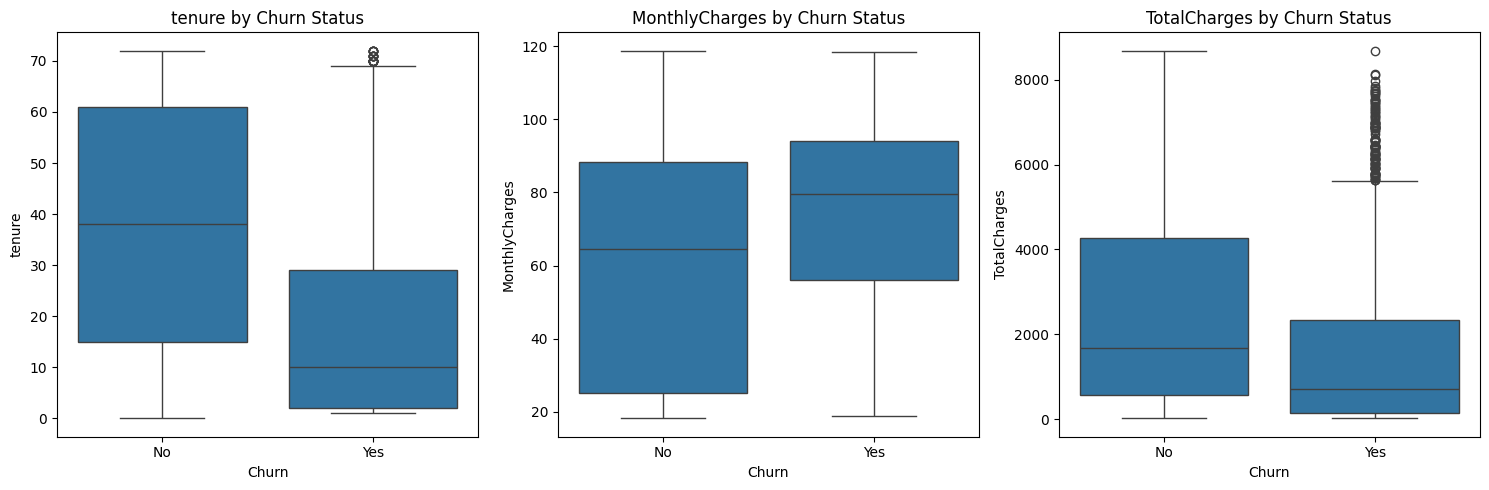

In [99]:
# Visualize distribution of numeric features by churn status
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Churn', y=feature, data=data)
    plt.title(f'{feature} by Churn Status')
plt.tight_layout()
plt.show()

In [ ]:
# #data = data.drop('CustomerID', axis=1)
# data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
# X= data.drop(['Churn', 'customerID', 'InternetService'], axis=1)
# y= data['Churn']
# categorical_cols = [col for col in categorical_cols if col != 'customerID']
# # Identifying categorical and numerical columns
# categorical_cols = data.select_dtypes(include=['object']).columns
# numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
# numeric_cols = numeric_cols.drop('Churn') # remove target from features
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# print("Categorical Columns:", list(categorical_cols))
# print("Numerical Columns:", list(numeric_cols))

Categorical Columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [113]:
# 1. Remove InternetService from the features
X = data.drop(['Churn', 'customerID', 'InternetService'], axis=1)
y = data['Churn']

# 2. Update your categorical columns list
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

print("Updated categorical columns:", categorical_cols)
print("Updated numeric columns:", numeric_cols)

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Create the preprocessor with the updated column lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Continue with the rest of your code...

Updated categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Updated numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
# # Create preprocessing pipeline
# # 1. For Numeric columns: standard scaling
# # 2. For categorical columns: one-hot encoding

# preprocessor = ColumnTransformer(
#     transformers= [
#         ('num', StandardScaler(), numeric_cols),
#         ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
#     ]
# )

In [114]:
# Lets see the shape of our training data
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (5634, 18)
Testing set shape: (1409, 18)


In [ ]:
# # Check what columns are in the dataset
# print("Columns in the dataset:", data.columns.tolist())

# # Identify categorical and numerical columns correctly
# categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
# numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# # Make sure 'Churn' is not in the feature columns (if it exists)
# if 'Churn' in numeric_cols:
#     numeric_cols.remove('Churn')

# print("Categorical columns:", categorical_cols)
# print("Numeric columns:", numeric_cols)

# # Now create X and y
# X = data.drop('Churn', axis=1)
# y = data['Churn']

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Create the preprocessor with handle_unknown
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_cols),
#         ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
#     ])

# # Apply preprocessing
# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

In [115]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply LAZYPREDICT
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_processed, X_test_processed, y_train, y_test)

print("Model Comparison:")
print(models)


 59%|█████▉    | 19/32 [00:02<00:01,  7.95it/s]/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
 97%|█████████▋| 31/32 [00:03<00:00, 10.63it/s]

[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328


/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 32/32 [00:03<00:00,  8.65it/s]

Model Comparison:
                               Accuracy  ...  Time Taken
Model                                    ...            
BernoulliNB                        0.73  ...        0.01
NearestCentroid                    0.69  ...        0.01
GaussianNB                         0.66  ...        0.01
LogisticRegression                 0.80  ...        0.02
LinearDiscriminantAnalysis         0.79  ...        0.01
LGBMClassifier                     0.80  ...        0.68
QuadraticDiscriminantAnalysis      0.73  ...        0.01
LinearSVC                          0.79  ...        0.01
CalibratedClassifierCV             0.79  ...        0.04
RidgeClassifier                    0.80  ...        0.01
RidgeClassifierCV                  0.80  ...        0.01
SVC                                0.79  ...        0.48
RandomForestClassifier             0.79  ...        0.25
XGBClassifier                      0.78  ...        0.20
AdaBoostClassifier                 0.79  ...        0.12
ExtraTreesCla

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

# create and train a Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_processed, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_processed)
y_pred_proba = log_reg.predict_proba(X_test_processed)[:,1]

# Evaluate the model
print("classification_report:")
print(classification_report(y_test, y_pred))


classification_report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



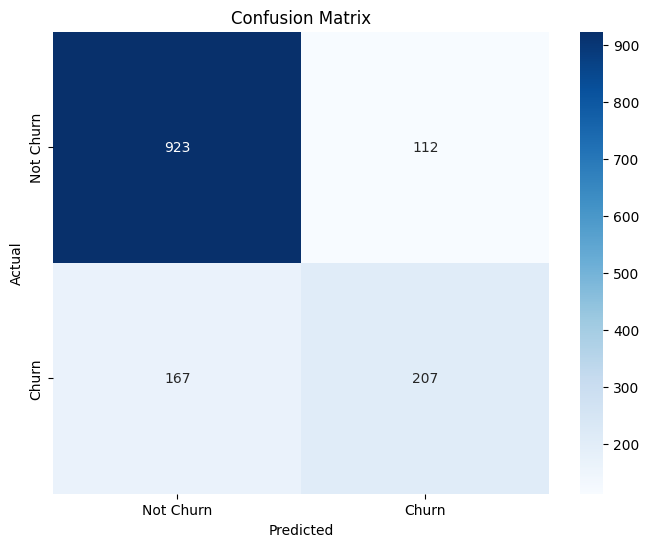

In [117]:
# Visualization
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churn', 'Churn'], 
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

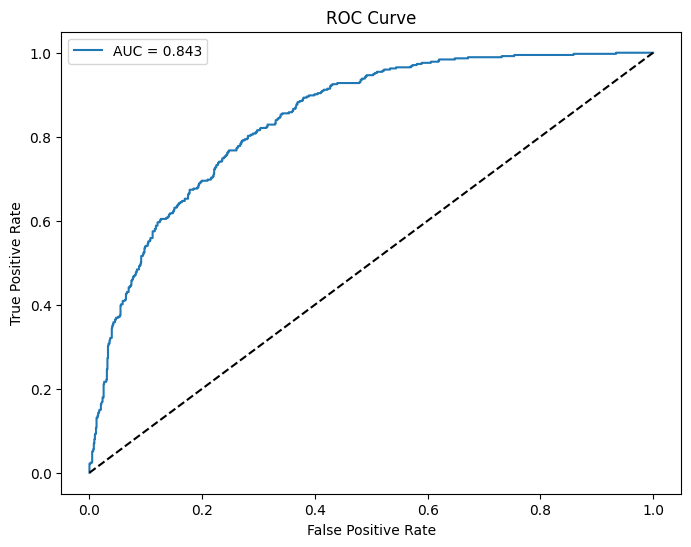

In [118]:
# Visulaization
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [119]:
# Hyper parameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1','l2', 'elasticnet', None],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid={
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2', None],
        'class_weight': [None, 'balanced']
    },
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_processed, y_train)
print("Best paramters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Best paramters: {'C': 10, 'class_weight': None, 'penalty': 'l2'}
Best accuracy: 0.8043999930654169


/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_rati

In [120]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_processed, y_train)
y_pred_best = best_model.predict(X_test_processed)
print("\nImproved Model Performance:")
print(classification_report(y_test,y_pred_best))


Improved Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



,Feature,Coefficient,Absolute Importance
23,cat__Contract_Two year,-1.38,1.38
1,num__tenure,-1.29,1.29
2,num__MonthlyCharges,0.91,0.91
7,cat__PhoneService_Yes,-0.76,0.76
22,cat__Contract_One year,-0.71,0.71
11,cat__OnlineSecurity_Yes,-0.58,0.58
3,num__TotalCharges,0.57,0.57
17,cat__TechSupport_Yes,-0.53,0.53
8,cat__MultipleLines_No phone service,0.40,0.40
26,cat__PaymentMethod_Electronic check,0.38,0.38


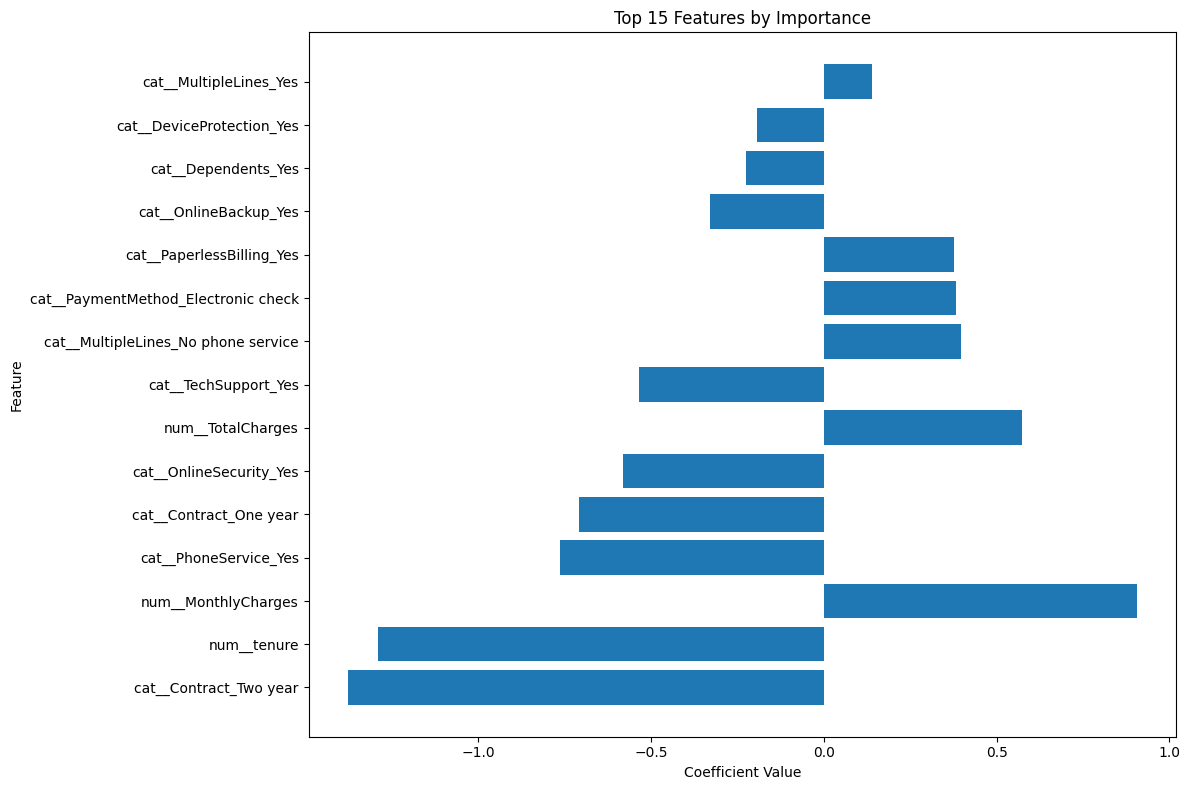

In [124]:
# Get feature importances from logistic regression coefficients
if hasattr(best_model, 'coef_'):
    # Get feature names from the preprocessor
    feature_names = preprocessor.get_feature_names_out()
    
    # Get coefficients and their absolute values
    coefficients = best_model.coef_[0]
    importance = np.abs(coefficients)
    
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute Importance': importance
    })
    
    # Sort by absolute importance
    importance_df = importance_df.sort_values('Absolute Importance', ascending=False)
    
    display(importance_df)

    # Plot top features
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][:15], importance_df['Coefficient'][:15])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    plt.show()

/var/folders/61/ylstgnh511z5l6cl_9t55ysc0000gn/T/ipykernel_12772/1158782077.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_processed,


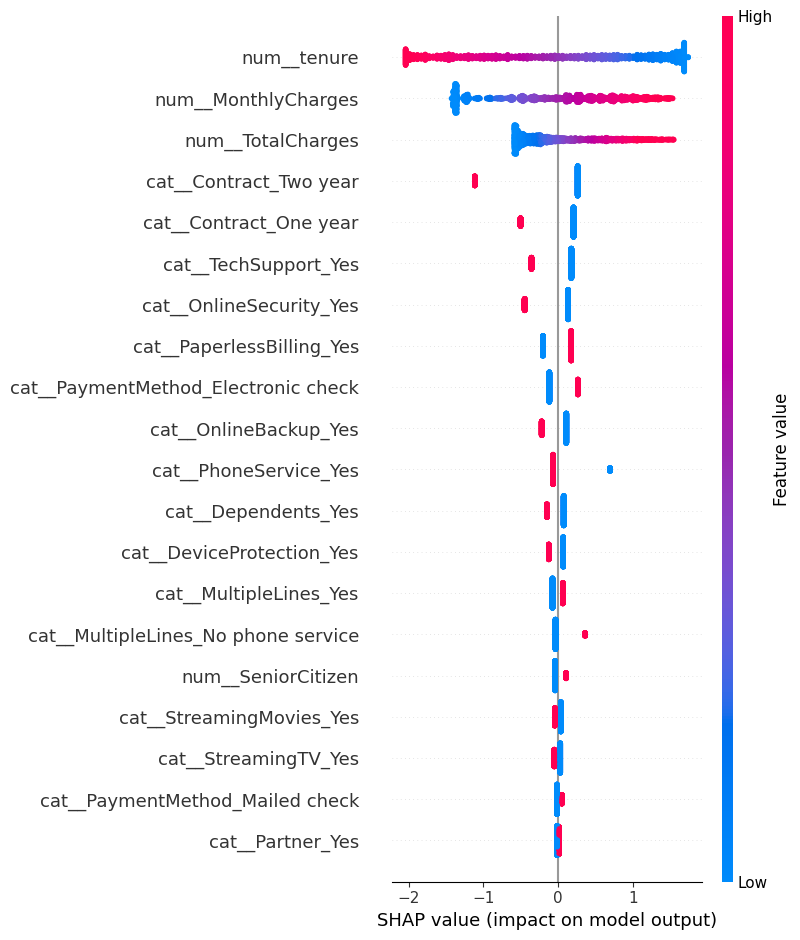

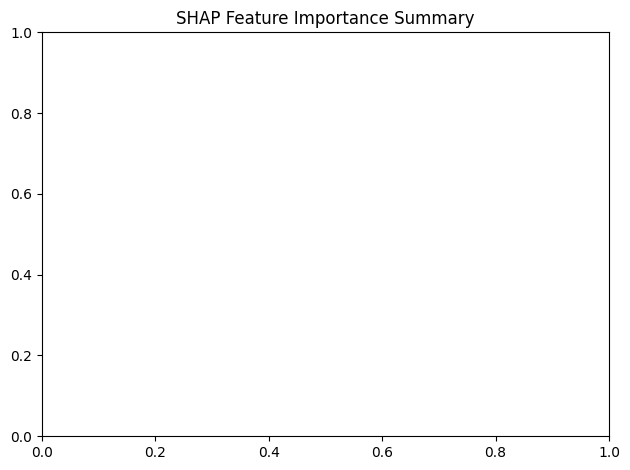

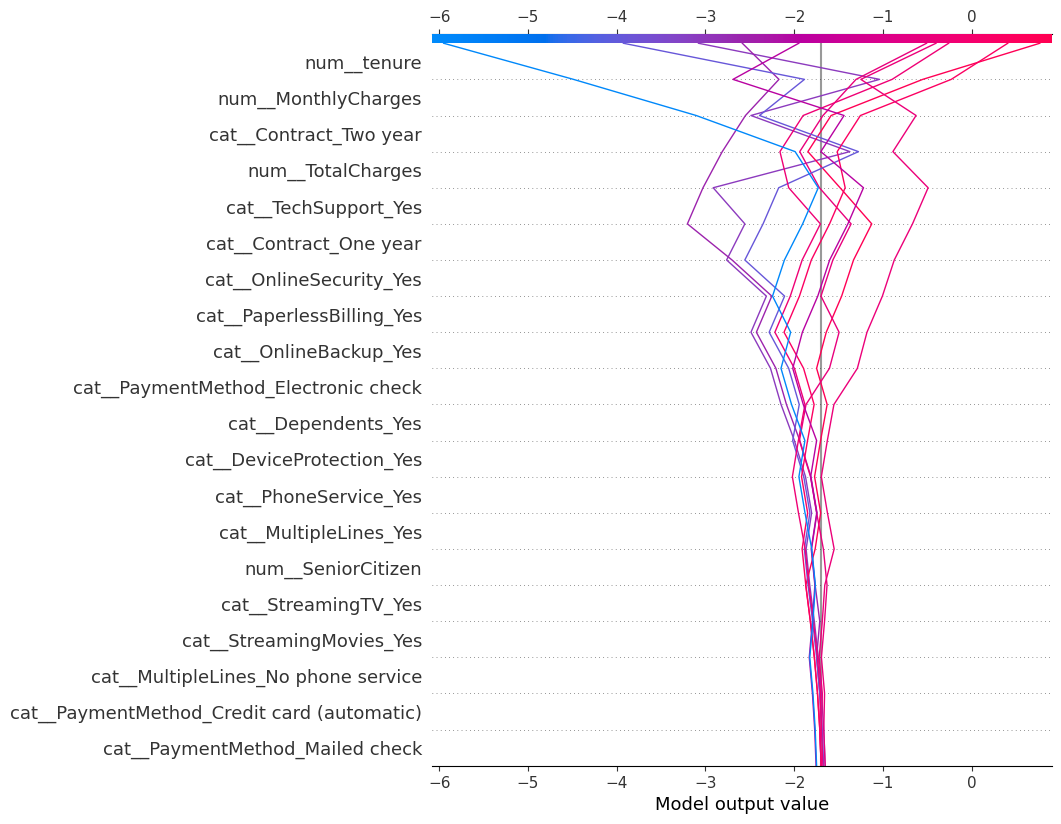

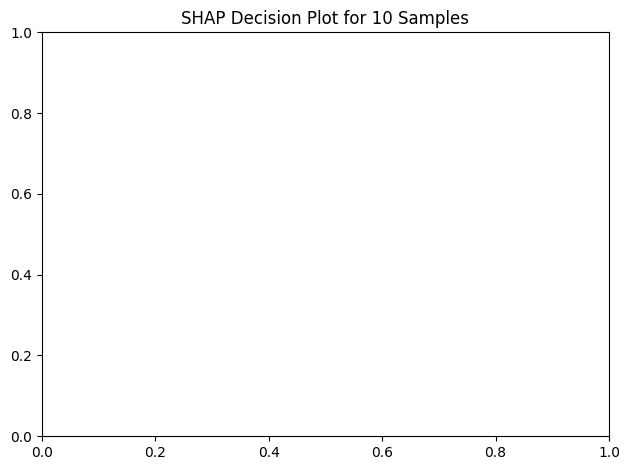

TypeError: bar() got an unexpected keyword argument 'feature_names'

<Figure size 1000x600 with 0 Axes>

In [123]:
# Import SHAP
import shap

# Calculate SHAP values for our logistic regression model
# First, let's create a proper explainer
explainer = shap.LinearExplainer(best_model, X_train_processed)

# Calculate SHAP values for a subset of test data
shap_values = explainer.shap_values(X_test_processed)

# Summary plot (should work fine)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_processed, 
                  feature_names=preprocessor.get_feature_names_out())
plt.title("SHAP Feature Importance Summary")
plt.tight_layout()
plt.show()

# Instead of force plot, let's try a decision plot which is often more reliable
plt.figure(figsize=(12, 8))
shap.decision_plot(explainer.expected_value, shap_values[:10], 
                  feature_names=preprocessor.get_feature_names_out())
plt.title("SHAP Decision Plot for 10 Samples")
plt.tight_layout()
plt.show()

# For individual explanations, let's use bar plots which are more reliable
sample_idx = 0  # First test sample
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values[sample_idx], feature_names=preprocessor.get_feature_names_out())
plt.title(f"Feature Contributions for Sample {sample_idx}")
plt.tight_layout()
plt.show()

# Let's also try the waterfall plot for a single prediction
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx], 
                                     base_values=explainer.expected_value,
                                     data=X_test_processed[sample_idx],
                                     feature_names=preprocessor.get_feature_names_out()))
plt.title(f"SHAP Waterfall Plot for Sample {sample_idx}")
plt.tight_layout()
plt.show()

